In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

核心思想：如果打乱target变量，好的特征就不再能有效的预测。如果打乱前和打乱后，该特征的feature importance没有明显变化，那就是坏的变量

In [2]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['label', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['label'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['label'].copy().sample(frac=1.0)#打乱标签
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params= {
        'bagging_freq': 5,
        'bagging_fraction': 0.9,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 1.0,
        'learning_rate': 0.05,
        'max_depth': -1,
        'metric':'auc_mu',
        'min_data_in_leaf': 10,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 4,
        'n_jobs': 12,
        'tree_learner': 'serial',
        'objective': 'multiclass',#多变量，单变量：binary
        'num_classes':6,
        'verbosity': -1
        }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]), multi_class='ovr',average='macro')
    
    return imp_df

In [6]:
data = pd.read_csv("C:/Users/nigel/Desktop/中兴/Data/train.csv").drop(columns = ['sample_id'])
categorical_feats = ['feature17', 'feature70', 'feature86']

In [7]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [8]:
actual_imp_df

,feature,importance_gain,importance_split,trn_score
0,feature0,408.674979,48,0.995848
1,feature1,128.026249,19,0.995848
2,feature2,71.400700,4,0.995848
3,feature3,495.672673,39,0.995848
4,feature4,0.000000,0,0.995848
...,...,...,...,...
100,feature100,51.469240,11,0.995848
101,feature101,96.637620,22,0.995848
102,feature102,38.653680,5,0.995848
103,feature103,10.703550,2,0.995848


In [24]:
null_imp_df = pd.DataFrame()
nb_runs = 200#跑多少次
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with  200 of  200 (Spent   2.9 min)

In [25]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

如果红色在蓝色右边：有效特征\
如果红色在蓝色左边：无效特征

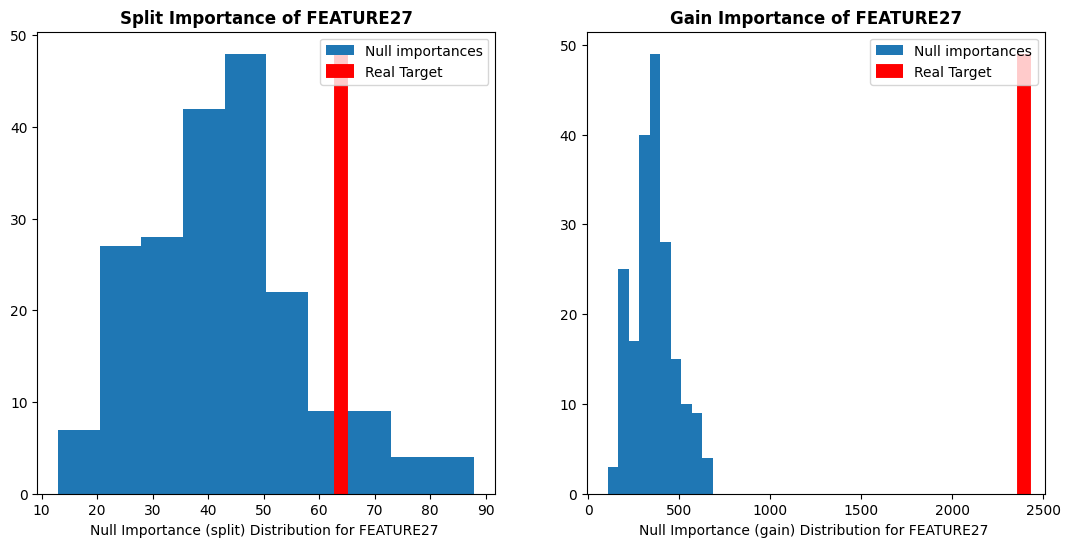

In [27]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature27')

给特征打分：\
计算真实得分相比于null importance远离了多少\
下面的代码是选了与null importance的75%相比\
越远离，得分越高

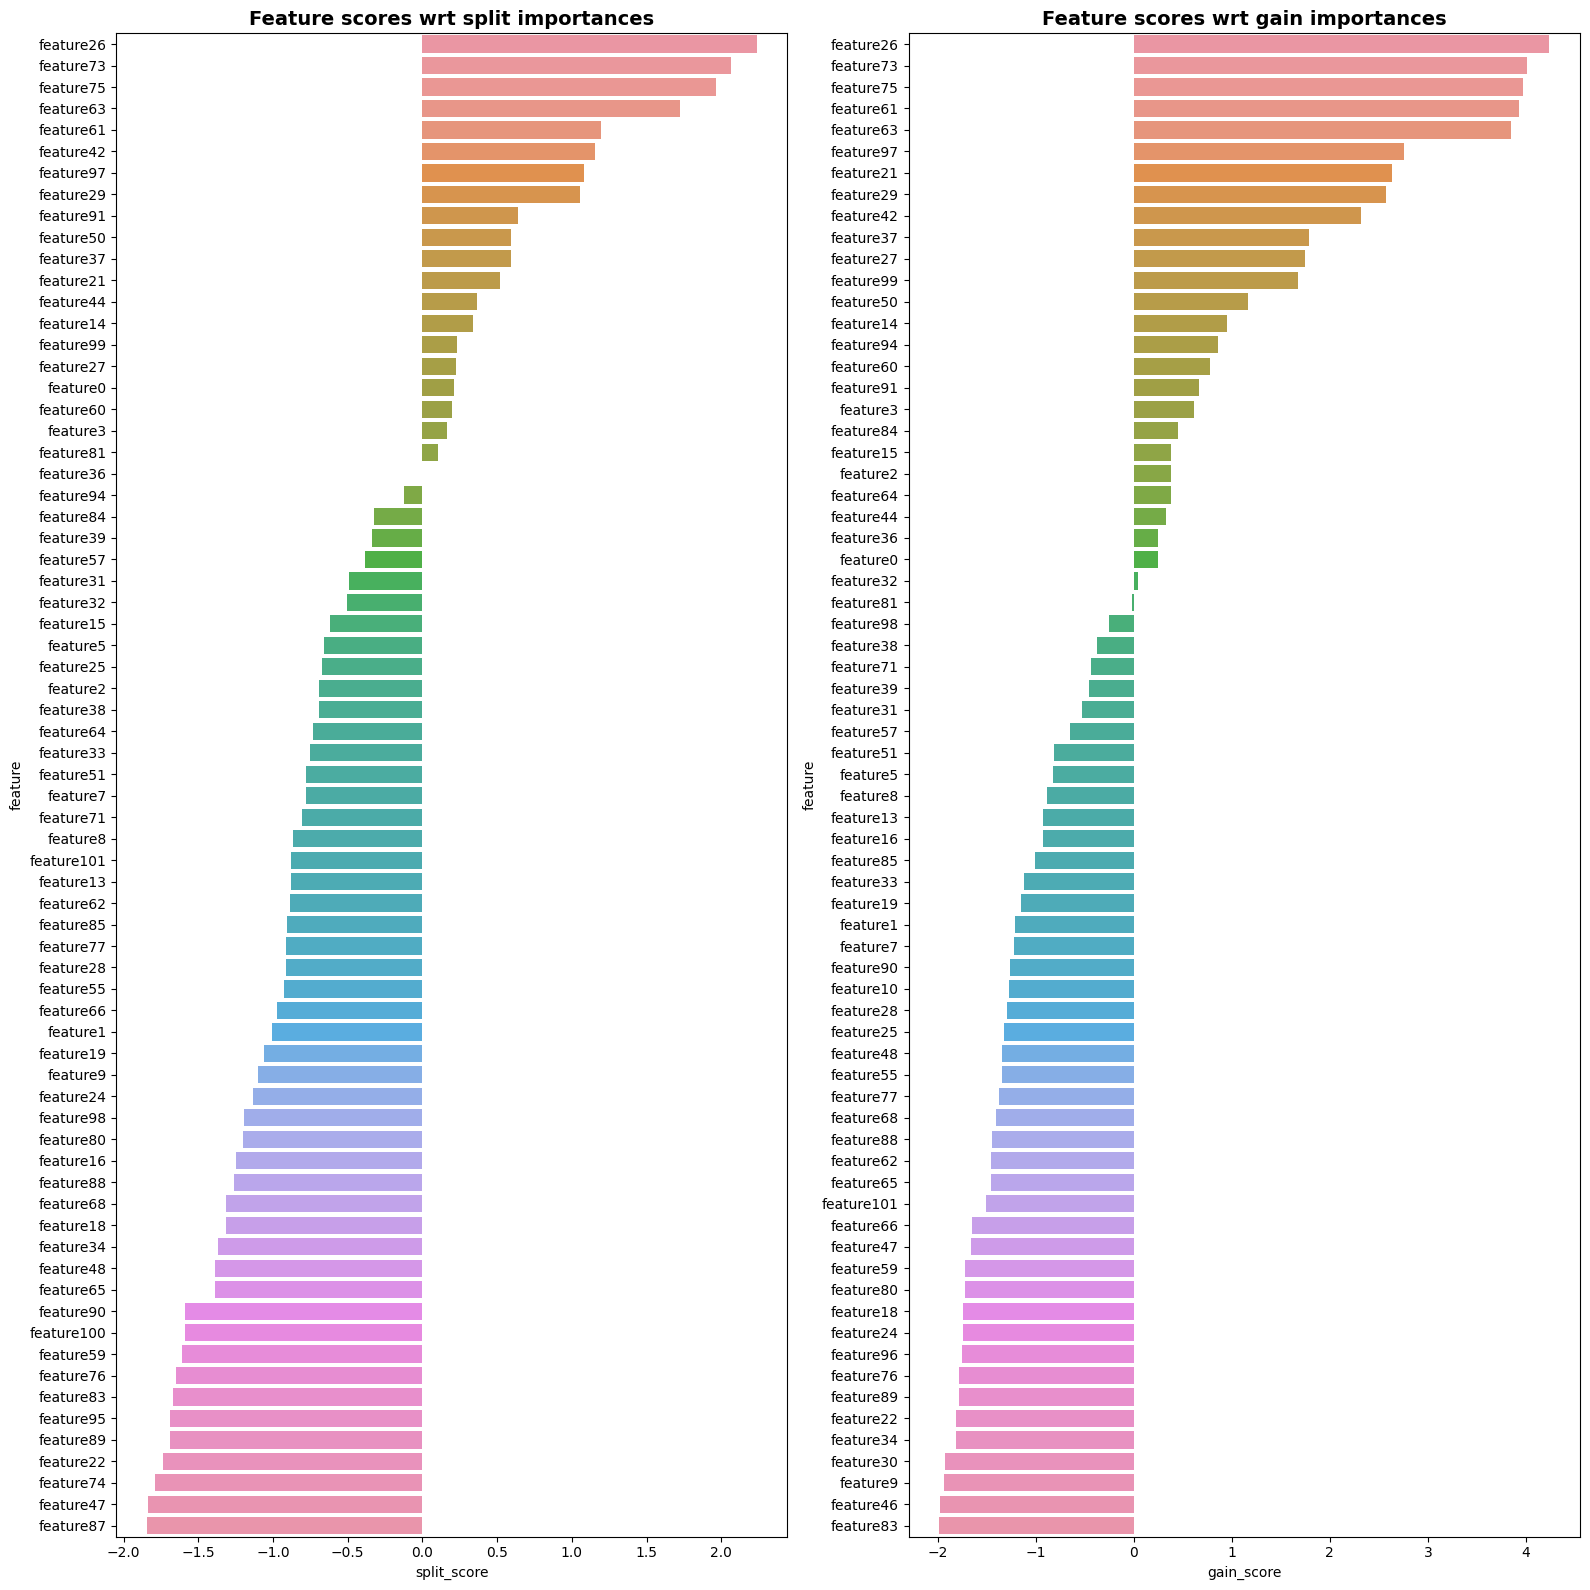

In [28]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [30]:
scores_df[scores_df['feature']=='feature27']

,feature,split_score,gain_score
27,feature27,0.227057,1.746229


In [42]:
scores_df.sort_values('split_score',ascending=False).iloc[:20,:]

,feature,split_score,gain_score
26,feature26,2.238656,4.241809
73,feature73,2.066054,4.010498
75,feature75,1.963522,3.971147
63,feature63,1.722767,3.850898
61,feature61,1.195486,3.929143
42,feature42,1.151647,2.313394
97,feature97,1.081434,2.759030
29,feature29,1.052521,2.568450
91,feature91,0.637577,0.663899
50,feature50,0.590290,1.166457


In [ ]:
scores_df.iloc[[i for i in range(len(scores_df)) if scores_df['split_score'][i]>0 and scores_df['gain_score'][i]>0],0]

In [ ]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

因为这里f_act_imps只有一个值，所以相当于计算：\
在null importance中，有百分之多少是会小于真实importance的\
很明显，如果想要真实importance与null importance越远离且大于，那计算的这个值越大越好

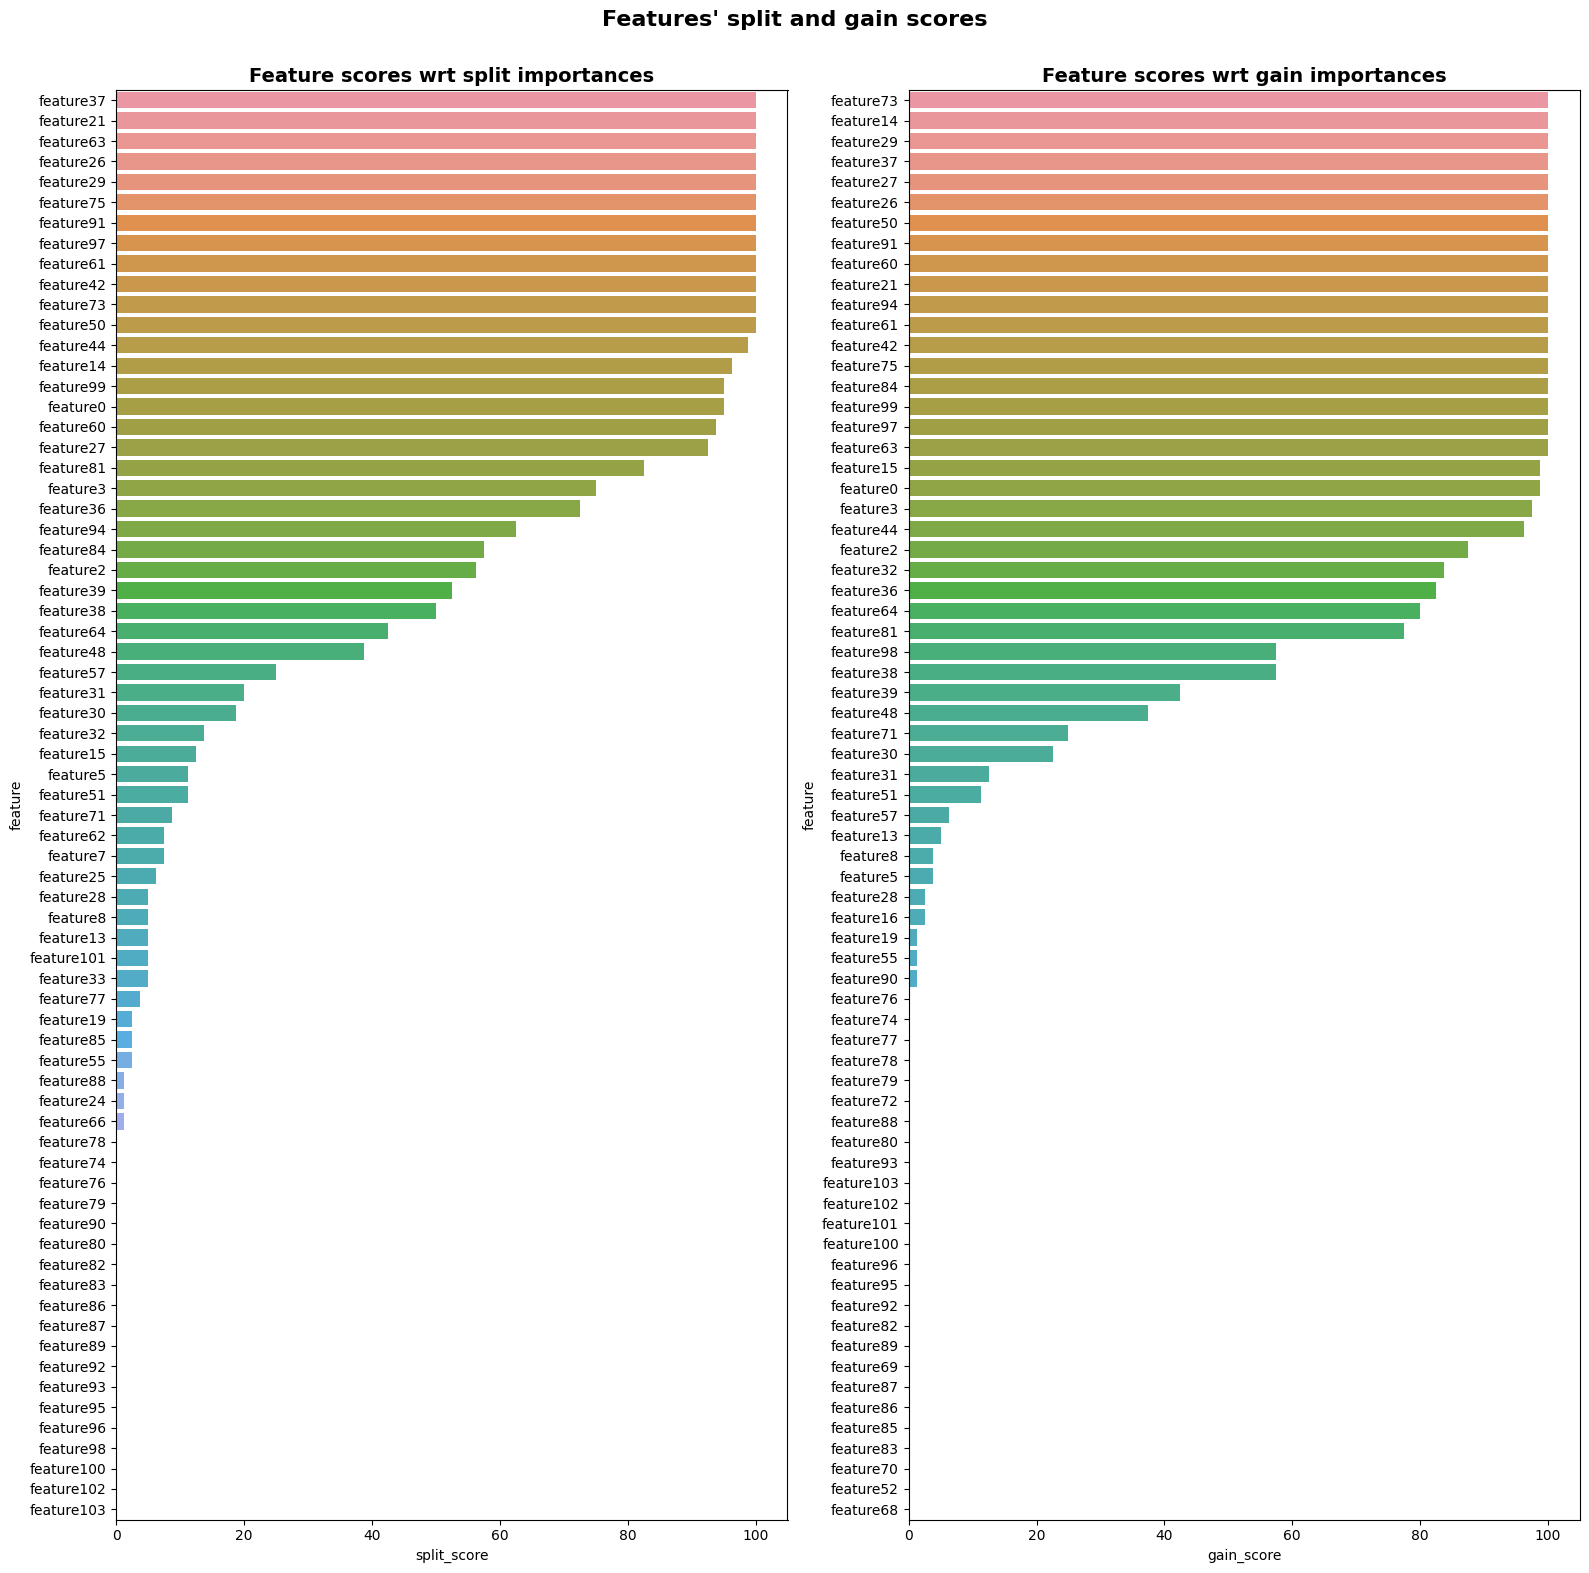

In [12]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size#统计在f_null_imps中，有多少小于25%的f_act_imps
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [44]:
correlation_scores


[('feature0', 95.0, 98.75),
 ('feature1', 0.0, 0.0),
 ('feature2', 56.25, 87.5),
 ('feature3', 75.0, 97.5),
 ('feature4', 0.0, 0.0),
 ('feature5', 11.25, 3.75),
 ('feature6', 0.0, 0.0),
 ('feature7', 7.5, 0.0),
 ('feature8', 5.0, 3.75),
 ('feature9', 0.0, 0.0),
 ('feature10', 0.0, 0.0),
 ('feature11', 0.0, 0.0),
 ('feature12', 0.0, 0.0),
 ('feature13', 5.0, 5.0),
 ('feature14', 96.25, 100.0),
 ('feature15', 12.5, 98.75),
 ('feature16', 0.0, 2.5),
 ('feature17', 0.0, 0.0),
 ('feature18', 0.0, 0.0),
 ('feature19', 2.5, 1.25),
 ('feature20', 0.0, 0.0),
 ('feature21', 100.0, 100.0),
 ('feature22', 0.0, 0.0),
 ('feature23', 0.0, 0.0),
 ('feature24', 1.25, 0.0),
 ('feature25', 6.25, 0.0),
 ('feature26', 100.0, 100.0),
 ('feature27', 92.5, 100.0),
 ('feature28', 5.0, 2.5),
 ('feature29', 100.0, 100.0),
 ('feature30', 18.75, 22.5),
 ('feature31', 20.0, 12.5),
 ('feature32', 13.75, 83.75),
 ('feature33', 5.0, 0.0),
 ('feature34', 0.0, 0.0),
 ('feature35', 0.0, 0.0),
 ('feature36', 72.5, 82.5),


In [45]:
[_f for _f, _score, _ in correlation_scores]

['feature0',
 'feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature19',
 'feature20',
 'feature21',
 'feature22',
 'feature23',
 'feature24',
 'feature25',
 'feature26',
 'feature27',
 'feature28',
 'feature29',
 'feature30',
 'feature31',
 'feature32',
 'feature33',
 'feature34',
 'feature35',
 'feature36',
 'feature37',
 'feature38',
 'feature39',
 'feature40',
 'feature41',
 'feature42',
 'feature43',
 'feature44',
 'feature45',
 'feature46',
 'feature47',
 'feature48',
 'feature49',
 'feature50',
 'feature51',
 'feature52',
 'feature53',
 'feature54',
 'feature55',
 'feature56',
 'feature57',
 'feature58',
 'feature59',
 'feature60',
 'feature61',
 'feature62',
 'feature63',
 'feature64',
 'feature65',
 'feature66',
 'feature67',
 'feature68',
 'feature69',
 'feature70',
 'feature71',
 '

根据split score和gain_score进行筛选\
split score是根据在null_importance 小于act_importance的占比计算的

In [ ]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params= {
        'bagging_freq': 5,
        'bagging_fraction': 0.9,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 1.0,
        'learning_rate': 0.05,
        'max_depth': -1,
        'metric':'auc_mu',
        'min_data_in_leaf': 10,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 4,
        'n_jobs': 12,
        'tree_learner': 'serial',
        'objective': 'multiclass',
        'num_classes':6,
        'verbosity': -1
        }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=-1,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc_mu-mean'][-1], hist['auc_mu-stdv'][-1]


for threshold in range(1,101,1):#[0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    print(f'Score in AUC')
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['label'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['label'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))
    print(" ")

In [33]:
threshold=20
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]

In [35]:
pd.DataFrame([i for i in split_feats if i not in gain_cat_feats],columns=['feature']).to_csv('f.csv',index=False)